In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import json
import csv
import os
import time

%matplotlib inline 

import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn import cluster, datasets, preprocessing, metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

## Data Retrieval

In [2]:
if not os.path.isdir('./player_data'):
    
    os.makedirs('./player_data', exist_ok=True)

    # Iterate through seasons.
    for i in range (1946, 2020):

        #no data for these years
        if i not in [1946, 1947, 1948, 1949, 1950]:
            continue

        time.sleep(3)

        # Get URL
        url_year_part = str(i) + '-' + str(i + 1)[-2:]
        url = 'https://stats.nba.com/stats/leagueLeaders?LeagueID=00&PerMode=PerGame&Scope=S&Season=' + url_year_part + '&SeasonType=Regular+Season&StatCategory=MIN'

        headers = {
            'referrer': 'https://google.com',
            'Accept': 'application/json, text/plain, */*',
            'Accept-Encoding': 'gzip, deflate, br',
            'Accept-Language': 'en-US,en;q=0.9',
            'Connection': 'keep-alive',
            'DNT': '1',
            'Host': 'stats.nba.com',
            'Referer': 'https://stats.nba.com/leaders/?Season=1950-51&SeasonType=Regular%20Season&StatCategory=MIN',
            'Sec-Fetch-Dest': 'empty',
            'Sec-Fetch-Mode': 'cors',
            'Sec-Fetch-Site': 'same-origin',
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
            'x-nba-stats-origin': 'stats',
            'x-nba-stats-token': 'true',
            'X-NewRelic-ID': 'VQECWF5UChAHUlNTBwgBVw=='
            }

        req = requests.get(url, headers=headers)
        print(url)

        stat_dict = json.loads(req.content)
        csv_path = 'player_data/' + url_year_part + '.csv'
        csv_columns = stat_dict['resultSet']['headers']
        with open(csv_path, 'w') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(csv_columns)
            for row in stat_dict['resultSet']['rowSet']:
                writer.writerow(row)


## Clustering Runs

Working on 1951...
Working on 1952...
Working on 1953...
Working on 1954...
Working on 1955...
Working on 1956...
Working on 1957...
Working on 1958...
Working on 1959...
Working on 1960...
Working on 1961...
Working on 1962...
Working on 1963...
Working on 1964...
Working on 1965...
Working on 1966...
Working on 1967...
Working on 1968...
Working on 1969...
Working on 1970...
Working on 1971...
Working on 1972...
Working on 1973...
Working on 1974...
Working on 1975...
Working on 1976...
Working on 1977...
Working on 1978...
Working on 1979...
Working on 1980...
Working on 1981...
Working on 1982...
Working on 1983...
Working on 1984...
Working on 1985...
Working on 1986...
Working on 1987...
Working on 1988...
Working on 1989...
Working on 1990...
Working on 1991...
Working on 1992...
Working on 1993...
Working on 1994...
Working on 1995...
Working on 1996...
Working on 1997...
Working on 1998...
Working on 1999...
Working on 2000...
Working on 2001...
Working on 2002...
Working on 2

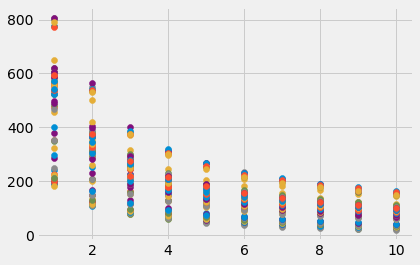

In [4]:
years = [x for x in os.listdir(path='./player_data') if x[-4:] == '.csv']
years.sort()

# initializing results list, with header row
headers = ['year', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']
results = [headers]

# year by year
#for year in range(1973, 2020):
for year in range(1951, 2020):
#for year in range(2019, 2020):
    testing = 0
    
    print('Working on {}...'.format(year))
    
    df = pd.read_csv('./player_data/' + str(year) + '-' + str(year + 1)[-2:] + '.csv')
    
    cols = ['PLAYER', 'GP', 'MIN']
    k_means_attributes = ['PTS', 'REB', 'AST']
    cols.extend(k_means_attributes)
    
    # Per 36 stats for K-Means attributes
    # Steals, Blocks start in 1973
    per_36 = df.loc[:,cols]
    for attrib in k_means_attributes:
        per_36.loc[:, attrib] = (per_36[attrib] * (36 / per_36['MIN'])).round(1)
    per_36.drop(['GP', 'MIN'], axis=1)
    
    # Checking relationships between pts, reb, ast
    #sns.pairplot(per_36[k_means_attributes])
    
    # Scaling
    scaler = preprocessing.StandardScaler()
    per_36_scaled = scaler.fit_transform(per_36[k_means_attributes])
        
    clusters = list(range(1, 11))
#    clusters = [3, 5]
    inertias = []
    silhouettes = []
    avg_dist_from_centroids = []
    
    for k in clusters:
        
        kmeans = cluster.KMeans(n_clusters=k)
        kmeans.fit(per_36_scaled)
        
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
        inertia = kmeans.inertia_
        #silhouette_score = metrics.silhouette_score(per_36_scaled, labels, metric='euclidean')
        
        # Equalizes inertia metric across different numbers of players in league 
        avg_dist_from_centroid = inertia/len(per_36_scaled)
        
        inertias.append(round(inertia, 1))
        #silhouettes.append(round(silhouette_score, 1))
        avg_dist_from_centroids.append(avg_dist_from_centroid)

        
        if testing == 1:
            
            # Gets statistical averages by cluster
            print(pd.Series(kmeans.labels_).groupby(level=0).count())
            cluster_avgs = pd.DataFrame(data=scaler.inverse_transform(centroids),
                                       columns=k_means_attributes)
            cluster_avgs.insert(0, column = 'label', value=cluster_avgs.index)
            #cluster_avgs.insert(1, column = 'n', value=)
            print(cluster_avgs)
            
            
    plt.scatter(clusters, inertias)
    #plt.scatter(clusters, silhouettes)
    
    avg_dist_from_centroids.insert(0, year)
    results.append(avg_dist_from_centroids)


# results to CSV
csv_path = 'k_means_results.csv'
with open(csv_path, 'w') as csvfile:
    writer = csv.writer(csvfile)
    for year in results:
        writer.writerow(year)

## Points of Interest

In [5]:
df = pd.read_csv('k_means_results.csv')
df.head()
print(df)

    year  one       two     three      four      five       six     seven  \
0   1951  3.0  1.848493  1.471374  1.174746  0.999033  0.868638  0.754586   
1   1952  3.0  1.972629  1.492516  1.142033  0.901915  0.778178  0.703585   
2   1953  3.0  1.810020  1.239339  0.952105  0.774378  0.660931  0.592296   
3   1954  3.0  1.783581  1.226210  0.897055  0.732998  0.625207  0.552261   
4   1955  3.0  1.731446  1.239021  1.001555  0.883439  0.762508  0.690187   
..   ...  ...       ...       ...       ...       ...       ...       ...   
64  2015  3.0  2.040784  1.425808  1.172330  0.993417  0.866313  0.759737   
65  2016  3.0  2.094387  1.486038  1.155783  0.998039  0.857921  0.773742   
66  2017  3.0  2.098790  1.494345  1.238152  1.031028  0.882899  0.808984   
67  2018  3.0  2.085481  1.454910  1.177867  0.997479  0.866173  0.793677   
68  2019  3.0  2.016259  1.424446  1.147343  0.927602  0.821133  0.734791   

       eight      nine       ten  
0   0.630307  0.551954  0.475341  
1   0

### Cluster grouping over time

Hopefully, we'll see our metric get closer to zero year over year for our three-cluster K-means runs, meaning that three clusters (point-wing-big) describes the data better over time.

And hopefully, it will get further from zero for our five-cluster K-means runs, as the point-shooting guard-small forward-power forward-center groupings fall out of fashion.

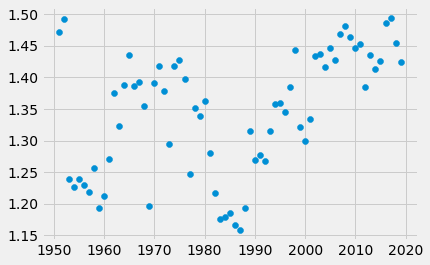

In [6]:
plt.scatter(x=df['year'], y=df['three'])

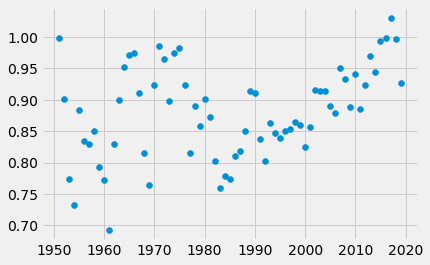

In [7]:
plt.scatter(x=df['year'], y=df['five'])

Nope. Cluster fit was scattered through the 70s, then hit a low point in the mid 80s, and has gradually increased in the time since.